# Testing new synthesis methods

In [1]:
import plenoptic as po
import torch
import matplotlib.pyplot as plt
# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams['figure.dpi'] = 72
import pytest
from torchvision.models import vgg16
%matplotlib inline
%load_ext autoreload
%autoreload 2

To get started, let's load an example image.

/home/billbrod/Documents/plenoptic/plenoptic/tools/data.py:126: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  images = torch.tensor(images, dtype=torch.float32)


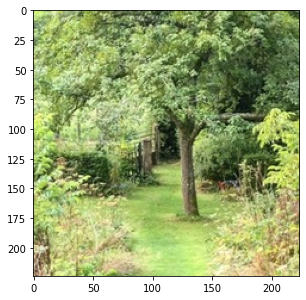

In [2]:
im = po.tools.load_images('../data/frontwindow.jpeg', as_gray=False)
im = im[...,300:524,300:524]
plt.imshow(im.squeeze().permute(1,2,0))

Now we will compare metamer synthesis for two models: Two different layers (pool1) and (pool2) from the VGG16 model. The initialization of these models is shown below. 

In [3]:
from torch import nn
model_vgg = vgg16(pretrained=True).eval()
# remove gradients from VGG parameters -- synthesis happens with a fixed model
po.tools.remove_grad(model_vgg)
model_pool1 = nn.Sequential(*list(model_vgg.children())[0][0:5])
model_pool2 = nn.Sequential(*list(model_vgg.children())[0][0:10])
synth_1 = po.synthesize.SimpleMetamer(im,model_pool1)
synth_2 = po.synthesize.SimpleMetamer(im, model_pool2)

/home/billbrod/miniconda3/envs/plenoptic/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/billbrod/miniconda3/envs/plenoptic/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/billbrod/Documents/plenoptic/plenoptic/tools/validate.py:178: UserWarning: model is in training mode, you probably want to call eval() to switch to evaluation mode
  warnings.warn(


In [4]:
synths =[synth_1, synth_2]
final_images = []
for synth in synths:
	# we do have a default optimizer, with a specific lr and other parameters -- 
	# if you want other than the default, create one and pass it to `synthesize`
	optim = torch.optim.Adam([synth.metamer], lr=.005)
	synth.synthesize(optimizer=optim, max_iter=20)
	# if we call synthesize again, resume where we left off. 
	# If you don't pass an optimizer object, we re-use the old one.
	synth.synthesize(max_iter=400)
	final_images.append(synth.metamer.squeeze().permute(1,2,0).detach())


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Let's look at the losses over time for both model synthesis runs!

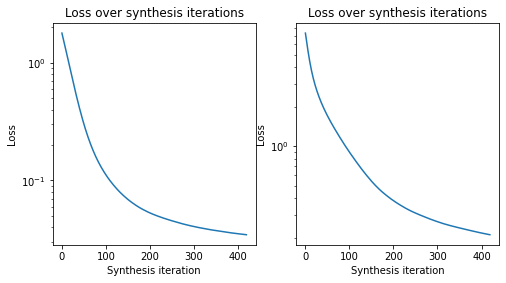

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
	ax[i].semilogy(synths[i].losses)
	ax[i].set(title="Loss over synthesis iterations", ylabel="Loss", xlabel="Synthesis iteration");

The left column below shows the target image and the following two images are the synthesized images for the pool1 and pool2 layers out of the VGG16 network.
We can see that, even though the target and synthesized images look *very* different, the difference between the representations (MSE loss between the representation of the synthesized images vs the target) is very small (see above).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


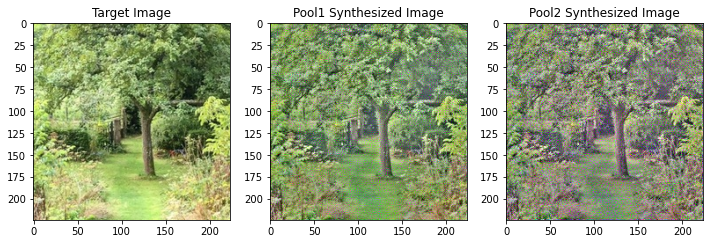

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
titles =["Target Image", "Pool1 Synthesized Image", "Pool2 Synthesized Image"] 
for i in range(3):
        if i == 0:
                ax[0].imshow(im.squeeze().permute(1,2,0))
                ax[0].set(title=titles[0])
        else:
                ax[i].imshow(final_images[i-1])
                ax[i].set(title=titles[i])

We also provide the methods `.to`, `.save`, and `.load`.

`.to` and `.save` work as you'd expect (`.to` works in place):

In [7]:
synth_1.save('pool1_synth.pt')

Because the models used in synthesis can be quite large and do not change during synthesis, we do not save them. Therefore, `.load` is an instance method: it must be called by an instance of the object, like so:

In [8]:
synth_1_reload = po.synthesize.SimpleMetamer(im, model_pool1)
print(torch.allclose(synth_1_reload.metamer, synth_1.metamer, atol=1e-2))
synth_1_reload.load('pool1_synth.pt')
print(torch.allclose(synth_1_reload.metamer, synth_1.metamer, atol=1e-2))

False
True


Because of this, we want to make sure the two versions were initialized in the same way; if you initialize `SimpleMetamer` with a different model or a different target image, it will raise an exception (in both cases, we catch this because `target_model_responses` is different, which is easier than checking whether the specific model is different):

In [9]:
synth_rand = po.synthesize.SimpleMetamer(torch.rand_like(im), model_pool1)
try:
    synth_rand.load('pool1_synth.pt')
except Exception as e:
    print(f'Exception: {e}')

Exception: Saved and initialized target_representation are different! Initialized: tensor([[[[1.2940e+00, 1.2684e+00, 5.9985e-01,  ..., 0.0000e+00,
           2.1817e+00, 0.0000e+00],
          [9.3261e-01, 0.0000e+00, 1.1335e+00,  ..., 0.0000e+00,
           1.5827e+00, 1.2735e+00],
          [1.6740e-01, 3.2275e-01, 1.7913e+00,  ..., 7.3143e-01,
           0.0000e+00, 6.3765e-01],
          ...,
          [1.9047e+00, 1.3920e+00, 0.0000e+00,  ..., 8.6144e-01,
           7.2117e-02, 1.6297e+00],
          [8.7329e-01, 0.0000e+00, 1.0439e+00,  ..., 2.1178e+00,
           1.6313e+00, 3.6696e-01],
          [0.0000e+00, 5.0109e-01, 1.2625e+00,  ..., 1.0994e+00,
           5.6918e-01, 5.1589e-01]],

         [[1.1823e+00, 1.0948e+00, 2.9793e-01,  ..., 4.7953e-02,
           1.1243e+00, 1.3186e+00],
          [0.0000e+00, 1.7813e-01, 2.9050e-01,  ..., 0.0000e+00,
           5.5044e-02, 1.7372e+00],
          [1.4719e+00, 0.0000e+00, 1.2800e+00,  ..., 0.0000e+00,
           0.0000e+00, 1.50